In [97]:
%matplotlib inline
import numpy as np
import re, os
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat

def chunk(bdata, size=8, dtype=float):
    if dtype == str:
        return [dtype(bdata[size*idx:size*(idx+1)]).strip() for idx in range(len(bdata)//size)]
    else:
        return [dtype(bdata[size*idx:size*(idx+1)]) for idx in range(len(bdata)//size)]

def strlist2type(dtype, strlist):
    return [dtype(item) for item in strlist]

class EDFData(object):

    def __init__(self, filename, expname, fs=2000):
        
        self.expname = expname
        
        with open(filename, 'rb') as f:
            
            ## header meta
            self.version = int(f.read(8).decode('ascii').strip())
            self.patient_info = f.read(80).decode('ascii').strip()
            self.record_info = f.read(80).decode('ascii').strip()
            self.start_date = f.read(8).decode('ascii').strip()
            self.start_time = f.read(8).decode('ascii').strip()
            self.header_length = int(f.read(8).decode('ascii').strip())
            
            self._reserved = f.read(44).decode('ascii').strip()
            
            self.recordnum = int(f.read(8).decode('ascii').strip())
            self.sampleduration = float(f.read(8).decode('ascii').strip())
            self.nchannel = int(f.read(4).decode('ascii').strip())
            
            ## header group
            self.channelLabels = chunk(f.read(16*self.nchannel).decode('ascii'), size=16, dtype=str)
            self.channelType   = chunk(f.read(80*self.nchannel).decode('ascii'), size=80, dtype=str)
            self.physical_dim  = chunk(f.read(8*self.nchannel).decode('ascii'),  size=8,  dtype=str)
            
            self.physical_min = chunk(f.read(8*self.nchannel), size=8, dtype=float)
            self.physical_max = chunk(f.read(8*self.nchannel), size=8, dtype=float)
            self.digital_min  = chunk(f.read(8*self.nchannel), size=8, dtype=int)
            self.digital_max  = chunk(f.read(8*self.nchannel), size=8, dtype=int)
            
            self.prefiltering = chunk(f.read(80*self.nchannel).decode('ascii'), size=80, dtype=str)
            
            self.samples = chunk(f.read(8*self.nchannel).decode('ascii'), size=8, dtype=int)
            try:
                self.reserved_samples = chunk(f.read(32*self.nchannel).decode('ascii'), size=8, dtype=int)
            except ValueError:
                self.reserved_samples = [0 for _ in range(self.nchannel)]
            
            ## data
            self.data = np.zeros((self.nchannel, self.recordnum * self.samples[0]), dtype='int16')
            #self.reserved_data = np.zeros((self.nchannel, self.recordnum * self.reserved_samples[0]), dtype='int16')
            
            step = np.sum(self.samples)
            for ri in range(self.recordnum):
                record_data = f.read(step * 2)
                self.data[:, self.samples[0]*(ri):self.samples[0]*(ri+1)] = np.ndarray((self.nchannel, self.samples[0]), buffer=record_data, dtype='int16')
                
            self.residual = f.read()  # residual should be empty
            
            ## 
            self.tspec = np.linspace(0, np.size(self.data, 1) / fs, np.size(self.data, 1))  # timeline
            self.fs = self.samples[0] / self.sampleduration
            self.physical_unit = (np.array(k.physical_max) - np.array(k.physical_min))/(np.array(k.digital_max) - np.array(k.digital_min))
    
    def splitinto(self, sgchdir):
        if not os.path.isdir(sgchdir):
            os.mkdir(sgchdir)
            
        for chidx in range(self.nchannel):
            chdir = os.path.join(sgchdir, "ch%03d"%chidx)
            if not os.path.isdir(chdir):
                os.mkdir(chdir)
            
            chfilename = "%s_ch%03d.mat"%(self.expname, chidx)
            savemat(os.path.join(chdir, chfilename), {
                "values": self.data[chidx,:],
                "markers": [0],
                "fs": self.fs,
                "physical_unit": self.physical_unit[chidx]
            })
            

In [127]:
example = "../Data/Yunfan Shu/EEG/EDF/16_5.edf"

%time k = EDFData(example, "180816-5-5")

CPU times: user 196 ms, sys: 242 ms, total: 439 ms
Wall time: 614 ms


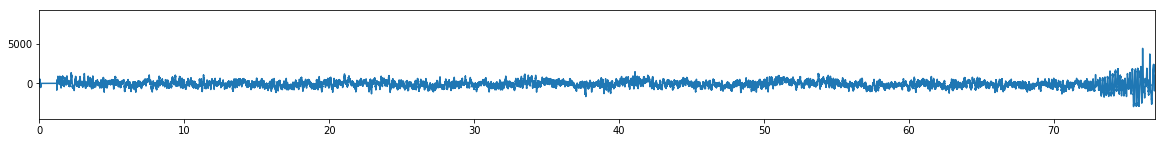

In [128]:
plt.figure(figsize=(20,2))
plt.plot(k.tspec, k.data[99,:])
plt.xlim([0,77])
plt.show()

In [129]:
k.splitinto("../Data/Yunfan Shu/EEG/SgCh")

In [130]:
k.sampleduration

0.1245

In [134]:
k.samples[0] / k.sampleduration

2000.0